In [1]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb

In [13]:
df = pd.read_csv("../data/processed/symmetric_matches.csv")
df = df[df["year"] > 2000]


In [14]:
df.columns

Index(['ATP', 'PlayerA', 'PlayerB', 'ARank', 'BRank', 'APts', 'BPts', 'Date',
       'Tournament', 'Round', 'avg_oddsA', 'avg_oddsB', 'max_oddsA',
       'max_oddsB', 'min_oddsA', 'min_oddsB', 'Agames', 'Bgames', 'Agameratio',
       'Bgameratio', 'rank_diff', 'points_diff', 'month', 'year',
       'series_ATP250', 'series_ATP500', 'series_Grand Slam',
       'series_International', 'series_International Gold', 'series_Masters',
       'series_Masters 1000', 'series_Masters Cup', 'surface_Carpet',
       'surface_Clay', 'surface_Grass', 'surface_Hard', 'round_1st Round',
       'round_2nd Round', 'round_3rd Round', 'round_4th Round',
       'round_Quarterfinals', 'round_Round Robin', 'round_Semifinals',
       'round_The Final', 'Outdoor', 'best_of_5', 'last_1_A', 'last_5_A',
       'last_15_A', 'last_1_tournament_A', 'last_5_tournament_A',
       'last_15_tournament_A', 'last_5_h2h_A', 'last_5_tournament_h2h_A',
       'finals_tournament_A', 'last_5_stage_A', 'last_1_B', 'last_5_B',
 

In [15]:
features = [
    "ATP",
    "ARank",
    "BRank",
    "APts",
    "BPts",
    "avg_oddsA",
    "avg_oddsB",
    "max_oddsA",
    "max_oddsB",
    "min_oddsA",
    "min_oddsB",
    "rank_diff",
    "points_diff",
    "month",
    "year",
    "series_ATP250",
    "series_ATP500",
    "series_Grand Slam",
    "series_International",
    "series_International Gold",
    "series_Masters",
    "series_Masters 1000",
    "series_Masters Cup",
    "surface_Carpet",
    "surface_Clay",
    "surface_Grass",
    "surface_Hard",
    "round_1st Round",
    "round_2nd Round",
    "round_3rd Round",
    "round_4th Round",
    "round_Quarterfinals",
    "round_Round Robin",
    "round_Semifinals",
    "round_The Final",
    "Outdoor",
    "best_of_5",
    "last_1_A",
    "last_5_A",
    "last_15_A",
    "last_1_tournament_A",
    "last_5_tournament_A",
    "last_15_tournament_A",
    "last_5_h2h_A",
    "last_5_tournament_h2h_A",
    "finals_tournament_A",
    "last_5_stage_A",
    "last_1_B",
    "last_5_B",
    "last_15_B",
    "last_1_tournament_B",
    "last_5_tournament_B",
    "last_15_tournament_B",
    "last_5_h2h_B",
    "last_5_tournament_h2h_B",
    "finals_tournament_B",
    "last_5_stage_B",
]

X = df[features].copy()
y = df["PlayerA_Won"].copy()


X_train = X[df["year"] < 2025]
X_test = X[df["year"] >= 2025]
y_train = y[df["year"] < 2025]
y_test = y[df["year"] >= 2025]



Dataset shape: (131918, 57)
Target shape: (131918,)

Training LightGBM model...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.601764

Model Performance:
Accuracy: 0.6724
Precision: 0.6737
Recall: 0.6688
F1-Score: 0.6712
AUC-ROC: 0.7344

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.68      0.67      2192
           1       0.67      0.67      0.67      2192

    accuracy                           0.67      4384
   macro avg       0.67      0.67      0.67      4384
weighted avg       0.67      0.67      0.67      4384



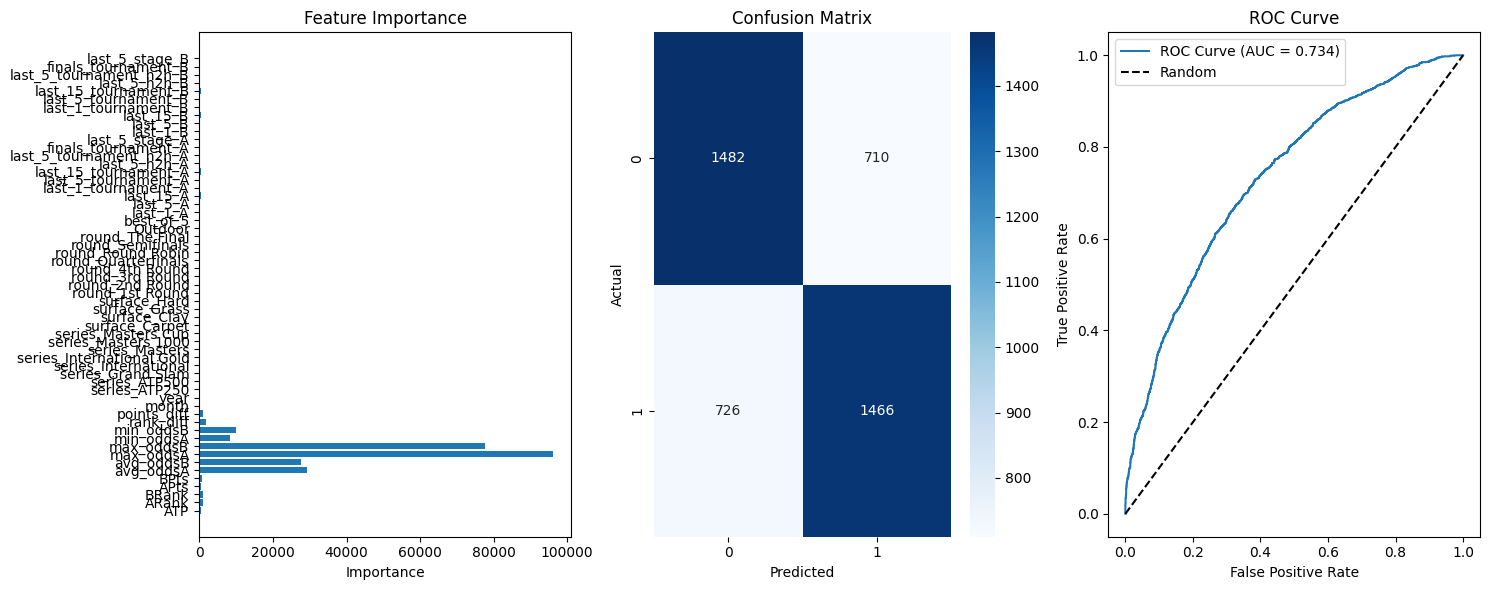

In [ ]:
# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters for LightGBM
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train the model
print("\nTraining LightGBM model...")
model = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=100,
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

# Make predictions
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

# Plot feature importance
feature_importance = model.feature_importance(importance_type='gain')
feature_names = X.columns

plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.barh(feature_names, feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance')

# Plot confusion matrix
plt.subplot(1, 3, 2)
cm = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.subplot(1, 3, 3)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.tight_layout()
plt.show()



Training Random Forest Classifier...

Model Performance:
Accuracy: 0.6556
Precision: 0.6573
Recall: 0.6501
F1-Score: 0.6537
AUC-ROC: 0.7222

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.66      0.66      2192
           1       0.66      0.65      0.65      2192

    accuracy                           0.66      4384
   macro avg       0.66      0.66      0.66      4384
weighted avg       0.66      0.66      0.66      4384



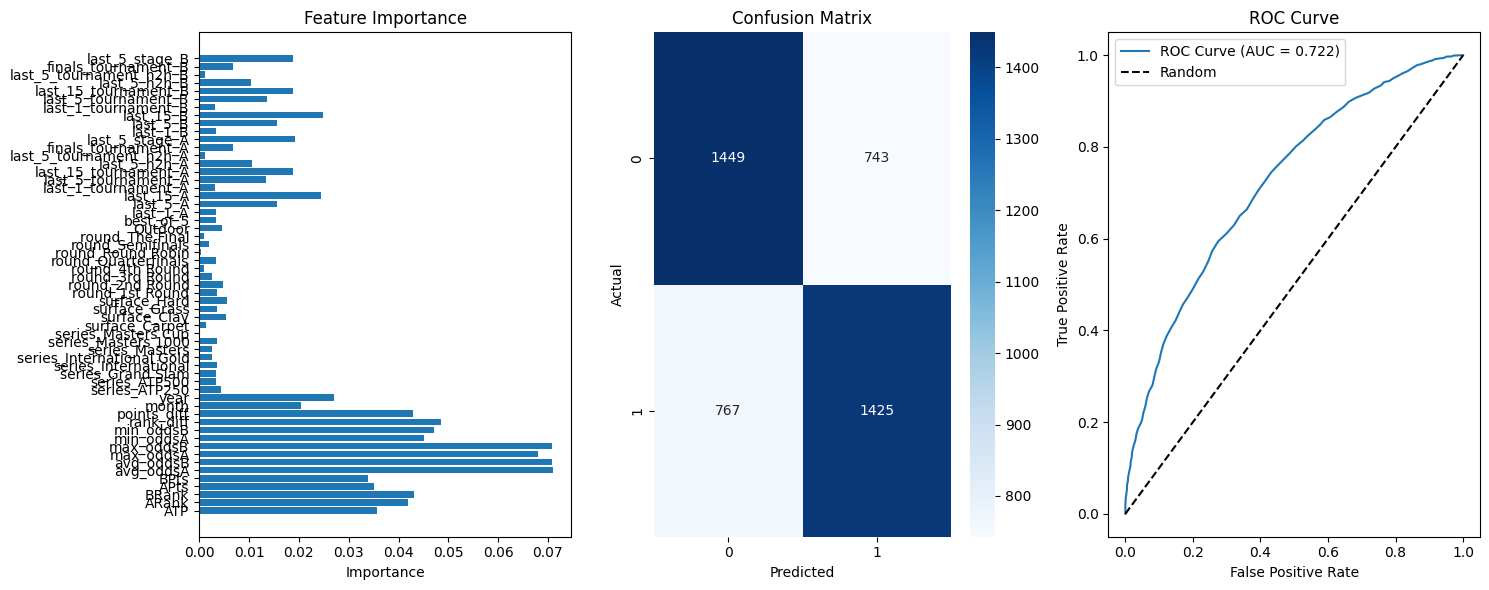

In [20]:
# Train a Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import numpy as np

print("\nTraining Random Forest Classifier...")
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Make predictions (probabilities for ROC/AUC, binary for metrics)
y_pred = model.predict_proba(X_test)[:, 1]
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

# Plot feature importance
feature_importance = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.barh(feature_names, feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance')

# Plot confusion matrix
plt.subplot(1, 3, 2)
cm = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.subplot(1, 3, 3)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.tight_layout()
plt.show()


Dataset shape: (131918, 57)
Target shape: (131918,)

Training Logistic Regression model...

Model Performance:
Accuracy: 0.6697
Precision: 0.6697
Recall: 0.6697
F1-Score: 0.6697
AUC-ROC: 0.7318

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67      2192
           1       0.67      0.67      0.67      2192

    accuracy                           0.67      4384
   macro avg       0.67      0.67      0.67      4384
weighted avg       0.67      0.67      0.67      4384



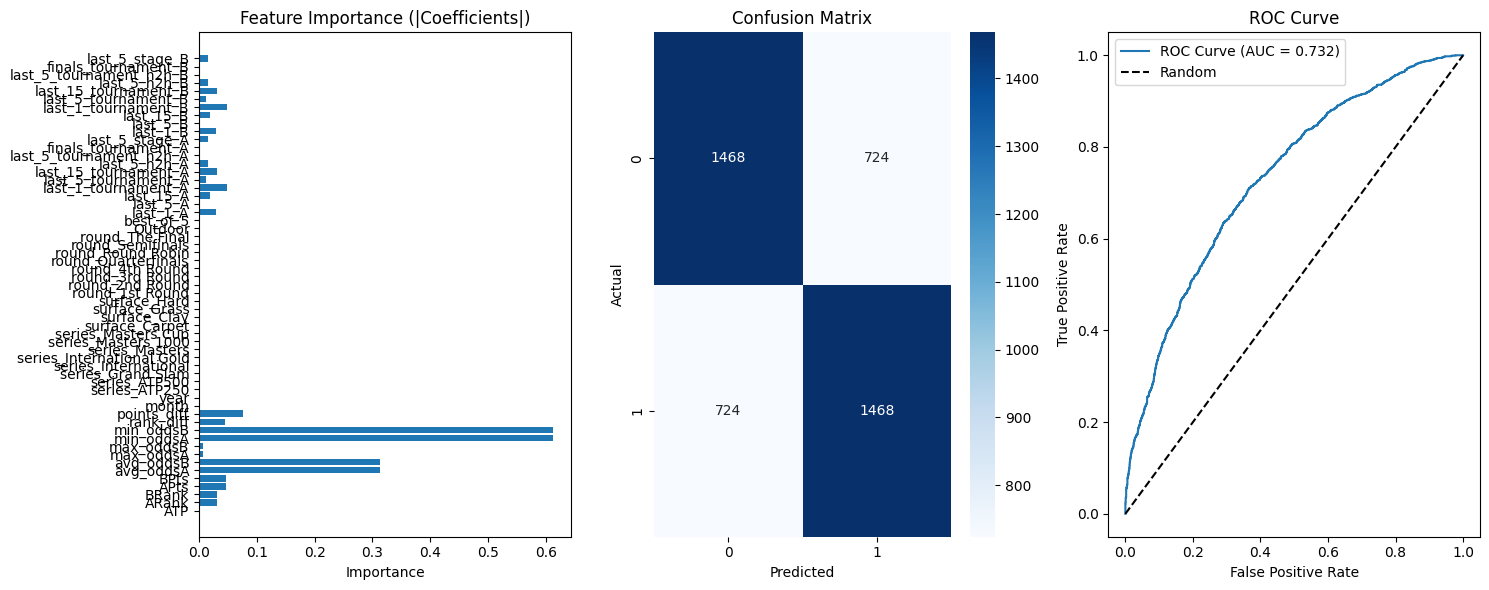

In [ ]:
# Scale the features for logistic regression
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression model
from sklearn.linear_model import LogisticRegression
print("\nTraining Logistic Regression model...")
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict_proba(X_test_scaled)[:, 1]  # Get probabilities for positive class

# Evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

# Plot feature importance (coefficients for logistic regression)
feature_importance = np.abs(model.coef_[0])
feature_names = X.columns

plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.barh(feature_names, feature_importance)
plt.title('Feature Importance (|Coefficients|)')
plt.xlabel('Importance')

# Plot confusion matrix
plt.subplot(1, 3, 2)
cm = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.subplot(1, 3, 3)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.tight_layout()
plt.show()


Dataset shape: (131918, 57)
Target shape: (131918,)

Training SVM model...

Model Performance:
Accuracy: 0.6649
Precision: 0.6659
Recall: 0.6620
F1-Score: 0.6639
AUC-ROC: 0.7218

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.67      0.67      2192
           1       0.67      0.66      0.66      2192

    accuracy                           0.66      4384
   macro avg       0.66      0.66      0.66      4384
weighted avg       0.66      0.66      0.66      4384



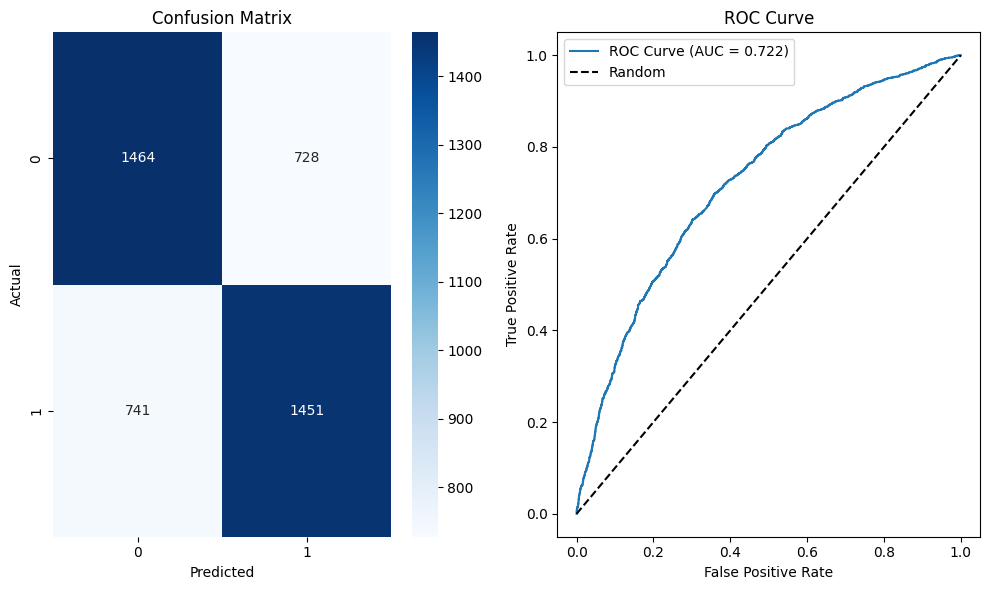

In [ ]:
# Scale the features for SVM
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM model
from sklearn.svm import SVC
print("\nTraining SVM model...")
model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,  # Enable probability estimates for ROC curve
    random_state=42
)

model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict_proba(X_test_scaled)[:, 1]  # Get probabilities for positive class

# Evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

# Note: SVM doesn't have built-in feature importance like tree-based models
# We'll use the absolute values of the coefficients for linear SVM or skip this plot
plt.figure(figsize=(10, 6))

# Plot confusion matrix
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.tight_layout()
plt.show()
